In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from to_sequences import to_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('./Fog.csv')
df.drop(df.index[df[(df.values == 'X') | \
    (df.values == 'V')].index], inplace=True)
df = df.drop(['time','Label'],axis=1)
df = df.astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 0 to 19679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    19659 non-null  float64
 1   dpTemp  19659 non-null  float64
 2   RH      19659 non-null  float64
 3   WDIR    19659 non-null  float64
 4   VIZ     19659 non-null  float64
dtypes: float64(5)
memory usage: 921.5 KB


In [4]:
df.corr()['VIZ']

temp      0.328069
dpTemp    0.075895
RH       -0.436874
WDIR     -0.102396
VIZ       1.000000
Name: VIZ, dtype: float64

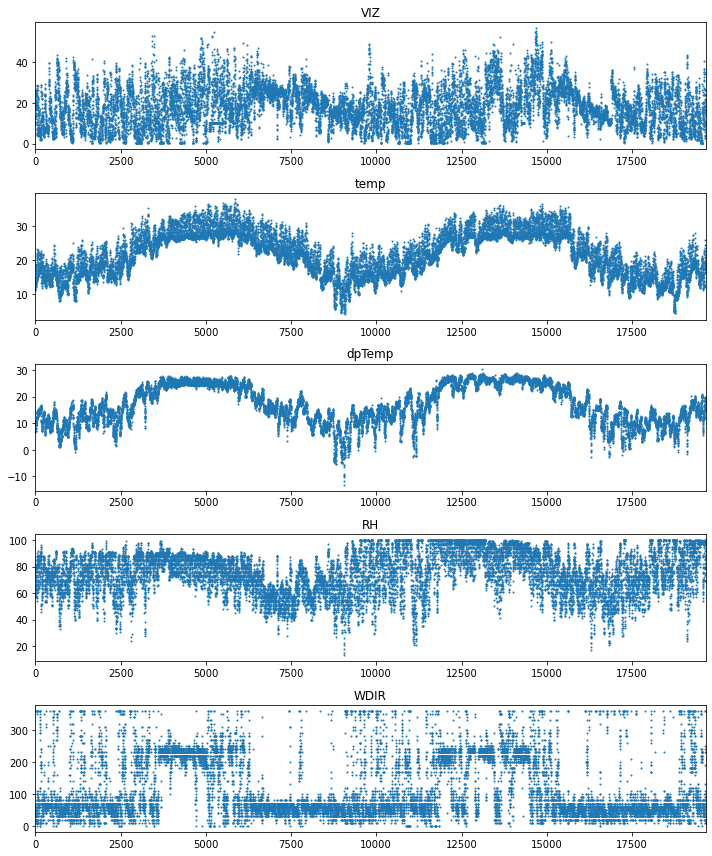

In [5]:
fig = plt.figure(figsize=(10, 12))

names = ('VIZ', 'temp', 'dpTemp', 'RH', 'WDIR')

for i in range(5):
    data = df[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    plt.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

In [6]:
# dataset = df.drop(['VIZ'], axis=1)
dataset = df.astype('float32')
dataset

,temp,dpTemp,RH,WDIR,VIZ
0,11.400000,6.700000,73.0,60.0,10.510000
1,11.300000,6.800000,74.0,50.0,9.940000
2,11.400000,6.900000,74.0,30.0,9.890000
3,11.300000,6.800000,74.0,40.0,10.410000
4,11.500000,7.000000,74.0,50.0,11.990000
...,...,...,...,...,...
19675,18.799999,18.799999,100.0,60.0,16.790001
19676,18.700001,18.200001,97.0,40.0,18.520000
19677,18.799999,18.299999,97.0,30.0,20.629999
19678,18.600000,18.299999,98.0,10.0,15.930000


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Also try QuantileTransformer
scalered = scaler.fit_transform(dataset)

scalerY = MinMaxScaler(feature_range=(0, 1))
Y = scalerY.fit_transform(dataset['VIZ'].values.reshape(-1, 1))
scalered.shape, Y.shape

((19659, 5), (19659, 1))

In [8]:
split = 0.2
slice_index = int(scalered.shape[0] * (1 - split))

train, test = scalered[:slice_index, :], scalered[slice_index:, :]
train.shape, test.shape, slice_index

((15727, 5), (3932, 5), 15727)

In [10]:
lookback = 72

trainX, trainY = to_sequences(train, lookback)
testX, testY = to_sequences(test, lookback)

In [11]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((15654, 72, 4), (15654,), (3859, 72, 4), (3859,))

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, -1))
testX = np.reshape(testX, (testX.shape[0], 1, -1))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, lookback*4)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20,
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()


Single LSTM with hidden Dense...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                90368     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 92,481
Trainable params: 92,481
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(trainX, trainY, validation_data=(testX, testY),
                    verbose=2, epochs=100)

Epoch 1/100
490/490 - 6s - loss: 0.0257 - val_loss: 0.0202 - 6s/epoch - 13ms/step
Epoch 2/100
490/490 - 2s - loss: 0.0222 - val_loss: 0.0182 - 2s/epoch - 3ms/step
Epoch 3/100
490/490 - 2s - loss: 0.0212 - val_loss: 0.0152 - 2s/epoch - 3ms/step
Epoch 4/100
490/490 - 2s - loss: 0.0209 - val_loss: 0.0157 - 2s/epoch - 3ms/step
Epoch 5/100
490/490 - 2s - loss: 0.0205 - val_loss: 0.0163 - 2s/epoch - 3ms/step
Epoch 6/100
490/490 - 2s - loss: 0.0203 - val_loss: 0.0156 - 2s/epoch - 3ms/step
Epoch 7/100
490/490 - 2s - loss: 0.0202 - val_loss: 0.0167 - 2s/epoch - 3ms/step
Epoch 8/100
490/490 - 2s - loss: 0.0196 - val_loss: 0.0164 - 2s/epoch - 3ms/step
Epoch 9/100
490/490 - 2s - loss: 0.0195 - val_loss: 0.0167 - 2s/epoch - 3ms/step
Epoch 10/100
490/490 - 2s - loss: 0.0192 - val_loss: 0.0193 - 2s/epoch - 3ms/step
Epoch 11/100
490/490 - 2s - loss: 0.0189 - val_loss: 0.0190 - 2s/epoch - 3ms/step
Epoch 12/100
490/490 - 2s - loss: 0.0186 - val_loss: 0.0211 - 2s/epoch - 3ms/step
Epoch 13/100
490/490 - 2

In [14]:
model.save('fog_model.h5')  # creates a HDF5 file 'my_model.h5'

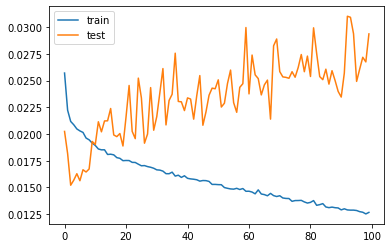

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

((15654, 1), (3859, 1))

In [17]:
trainY.shape, testY.shape

((15654,), (3859,))

In [18]:
trainPredict = scalerY.inverse_transform(trainPredict)
invTrainY = scalerY.inverse_transform([trainY])
testPredict = scalerY.inverse_transform(testPredict)
invTestY = scalerY.inverse_transform([testY])
trainPredict.shape, invTrainY.shape, testPredict.shape, invTestY.shape


((15654, 1), (1, 15654), (3859, 1), (1, 3859))

In [19]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 6.27 RMSE
Test Score: 9.74 RMSE


In [20]:
trainPredictPlot = np.empty_like(dataset.values[:, 0].reshape(-1, 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset.values[:, 0].reshape(-1, 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict


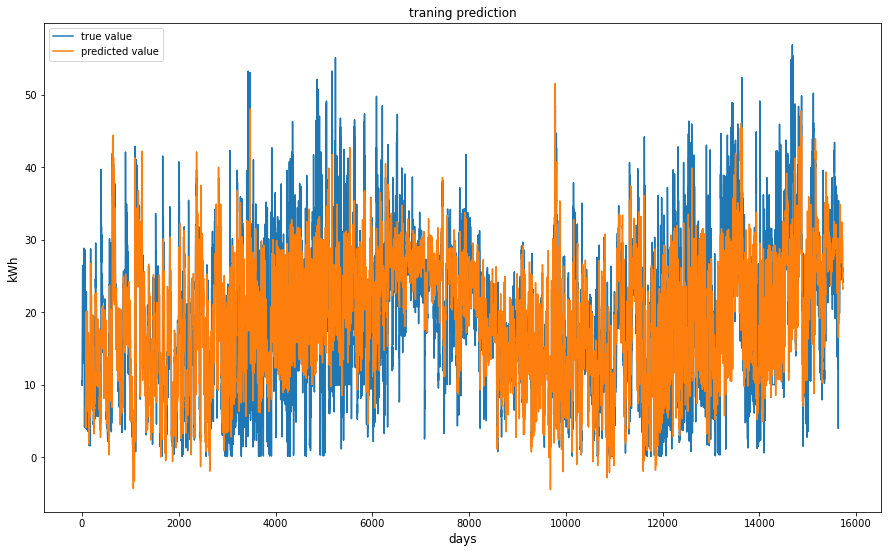

In [21]:
plt.figure(figsize=(15, 9))
plt.title('traning prediction', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.xlabel('days', fontsize=12)
plt.plot(dataset.values[:slice_index, 4], label='true value')
plt.plot(trainPredictPlot[:slice_index], label='predicted value')
plt.legend()
plt.show()


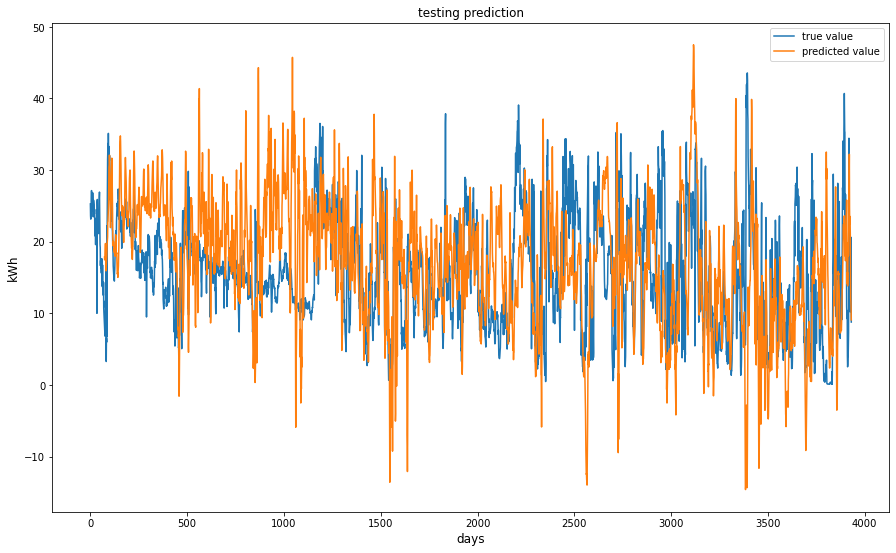

In [22]:
plt.figure(figsize=(15, 9))
plt.title('testing prediction', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.xlabel('days', fontsize=12)
plt.plot(dataset.values[slice_index:, 4], label='true value')
plt.plot(testPredictPlot[slice_index:], label='predicted value')
plt.legend()
plt.show()
